# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
import numpy as np
import torch
from IPython.display import clear_output
from matplotlib import pyplot as plt
import utils as ut
import train_dqn as tdqn

# Check that current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# Check that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


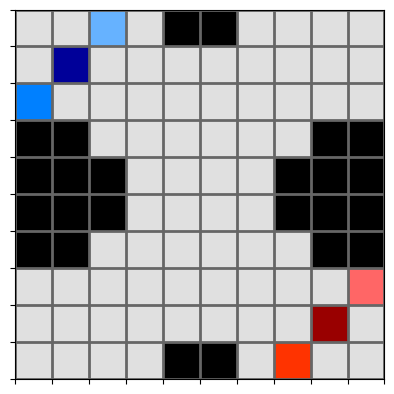

In [2]:
# instantiate environment
env = GridworldCtf(game_mode='random')
env.render()

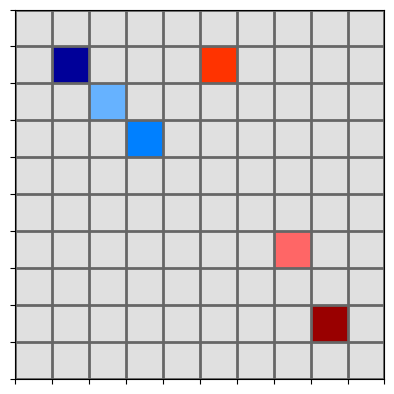

You win!, total score 235


In [3]:
# example against random agents
env.play()

## Deep Q-Network

### Train agents

In [7]:
# create environment
env = GridworldCtf(game_mode='static')
device = "cpu"

# configure agents
batch_size = 32
gamma = 0.9
lr = 0.000025
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
n_actions = 4
use_softmax = True
loss='mse'

agent_t1 = DQNAgent(q_network=DQNNetwork(name='dqn_t1', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax,
                loss=loss)

agent_t2 = DQNAgent(q_network=DQNNetwork(name='dqn_t2', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax,
                loss=loss)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                env_dims=(1, 1, 10, 10),
                                epochs=2000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                device='cpu')

episode: 1995 
total step count: 214573 
episode step count: 64                 
score: 249 
average score: 186.39                 
epsilon: 0.1359 
done count: 1986                 
team 1 captures: 3658 
team 2 captures: 5743


In [8]:
# save models
agent_t1.save_model()
agent_t2.save_model()

#### Performance metrics

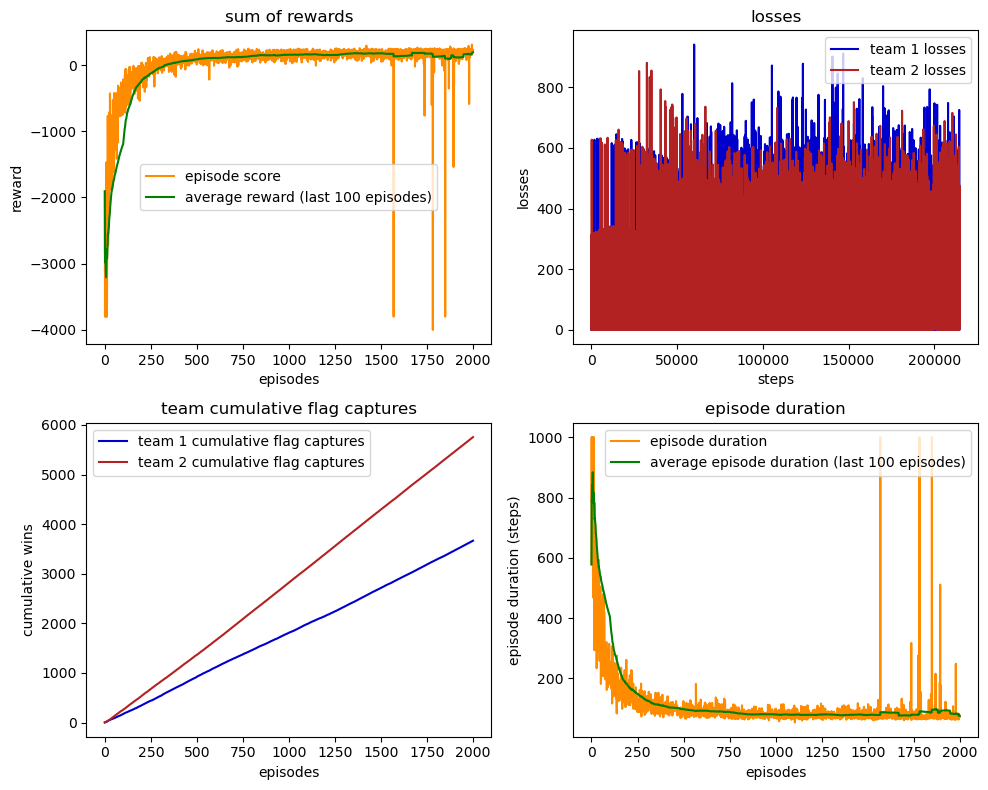

In [9]:
ut.plot_training_performance(*training_metrics)

#### Inference

In [ ]:
# load saved network weights
dqn_t1 = DQNNetwork(name='dqn_t1')
dqn_t1.load_model()

dqn_t2 = DQNNetwork(name='dqn_t2')
dqn_t2.load_model()

# create agents
use_softmax = True
agent_t1 = DQNAgent(q_network=dqn_t1 ,
                    use_softmax=use_softmax)

agent_t2 = DQNAgent(q_network=dqn_t2,
                    use_softmax=use_softmax)

# create environment
env = GridworldCtf()           
env_dims = (1, 1, 10, 10)

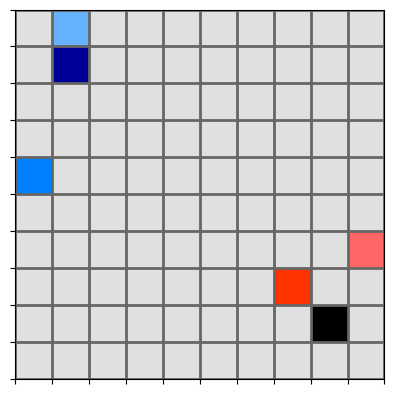

Game won!                       
Final score: 56                       
Team 1 score: 1                       
Team 2 score: 3                       
Total moves: 87


In [13]:
# test model
ut.test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=200)

#### Interactive play with trained agents

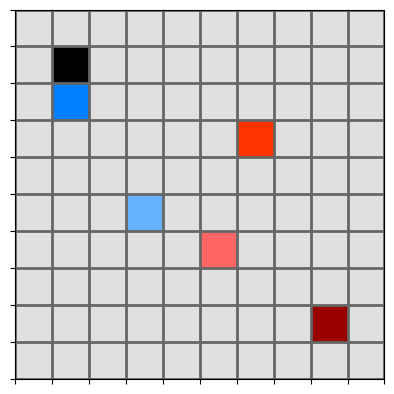

You win!, total score 141


In [12]:
env = GridworldCtf(game_mode='static')
env.play(player=0, agents=[agent_t1, agent_t2])

## Double DQN

In [24]:
# create environment
env = GridworldCtf(game_mode='static')
device = "cpu"

# configure agents
batch_size = 32
gamma = 0.9
lr = 0.000025
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
n_actions = 4
use_softmax = True
loss = 'mse'
ddqn = True

agent_t1 = DQNAgent(q_network=DQNNetwork(name='ddqn_t1', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax,
                loss=loss,
                ddqn=ddqn)

agent_t2 = DQNAgent(q_network=DQNNetwork(name='ddqn_t2', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax,
                loss=loss,
                ddqn=ddqn)

# train agents
training_metrics = tdqn.train_dqn(env,
                                agent_t1,
                                agent_t2,
                                env_dims=(1, 1, 10, 10),
                                epochs=2000,
                                batch_size=batch_size,
                                epsilon=epsilon,
                                epsilon_decay=0.999,
                                epsilon_min=0.1,
                                n_random_steps=0,
                                max_steps=1000,
                                learning_skip_steps=1,
                                device='cpu')

episode: 1995 
total step count: 239387 
episode step count: 71                 
score: 19 
average score: 45.97                 
epsilon: 0.1359 
done count: 1989                 
team 1 captures: 2973 
team 2 captures: 5824


In [21]:
# save models
agent_t1.save_model()
agent_t2.save_model()

#### Performance metrics

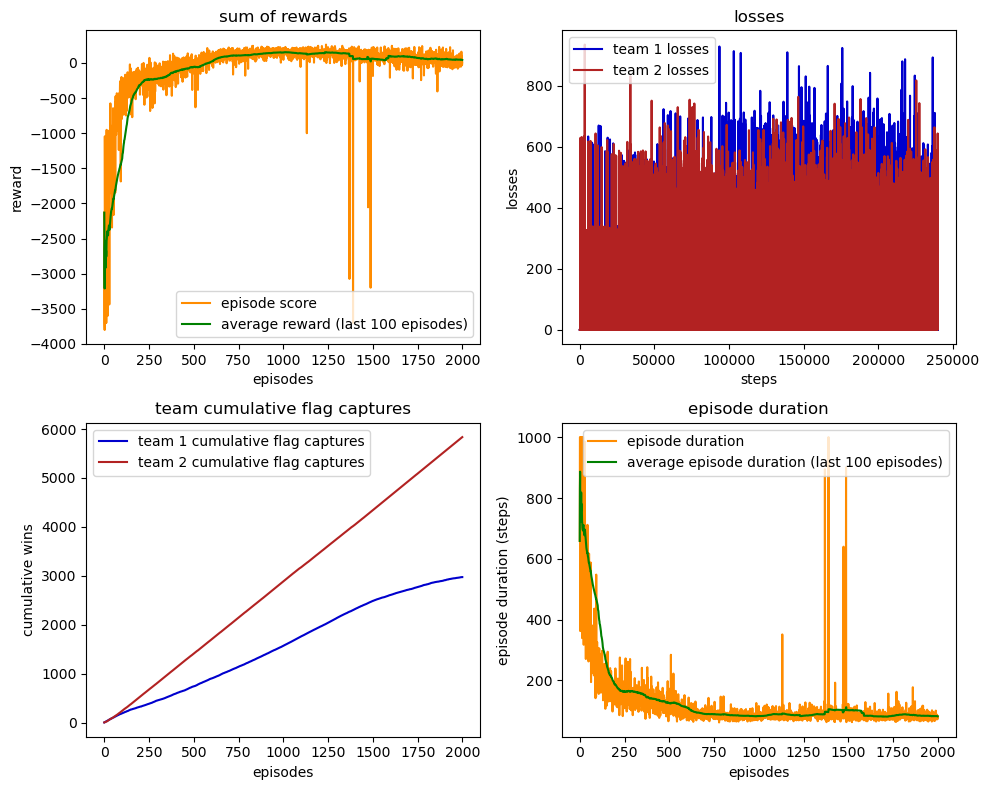

In [25]:
ut.plot_training_performance(*training_metrics)

#### Inference

In [22]:
# load saved network weights
ddqn_t1 = DQNNetwork(name='ddqn_t1')
ddqn_t1.load_model()

ddqn_t2 = DQNNetwork(name='ddqn_t2')
ddqn_t2.load_model()

# create agents
use_softmax = True
agent_t1 = DQNAgent(q_network=ddqn_t1 ,
                    use_softmax=use_softmax)

agent_t2 = DQNAgent(q_network=ddqn_t2,
                    use_softmax=use_softmax)

# create environment
env = GridworldCtf()           
env_dims = (1, 1, 10, 10)

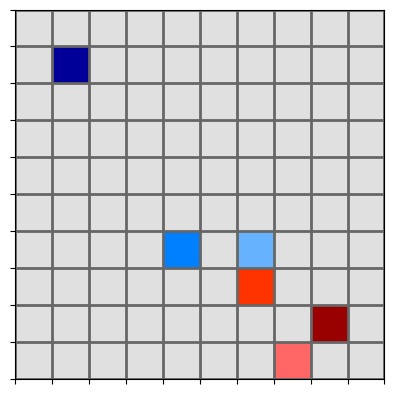

Game won!                       
Final score: 20                       
Team 1 score: 1                       
Team 2 score: 3                       
Total moves: 96


In [27]:
# test model
ut.test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=200)